In [1]:
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from sklearn import datasets

In [25]:
def divide_on_feature(x, feature_i, threshold):
    #Split data into two parts based on if x[feature_i]>=threshold
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    x1 = np.array([sample for sample in x if split_func(sample)])
    x2 = np.array([sample for sample in x if not split_func(sample)])

    return np.array([x1, x2])
"""
def divide_on_feature(X, feature_i, threshold):
    # Divide dataset based on if sample value on feature index is larger than the given threshold
    split_func = None
    if isinstance(threshold, int) or isinstance(threshold, float):
        split_func = lambda sample: sample[feature_i] >= threshold
    else:
        split_func = lambda sample: sample[feature_i] == threshold

    X_1 = np.array([sample for sample in X if split_func(sample)])
    X_2 = np.array([sample for sample in X if not split_func(sample)])

    return np.array([X_1, X_2])
"""

def calculate_variance(x):
    """ Return the variance of the features in dataset X """
    mean = np.ones(np.shape(x)) * x.mean(0)
    n_samples = np.shape(x)[0]
    variance = (1 / n_samples) * np.diag((x - mean).T.dot(x - mean))
    return variance

def calculate_entropy(y):
    """ Calculate the entropy of label array y """
    log2 = lambda x: math.log(x) / math.log(2)
    unique_labels = np.unique(y)
    entropy = 0
    for label in unique_labels:
        count = len(y[y == label])
        p = count / len(y)
        entropy += -p * log2(p)
    return entropy

def get_random_subsets(X, y, n_subsets, replacements=True):
    """ Return random subsets (with replacements) of the data """
    n_samples = np.shape(X)[0]
    # Concatenate x and y and do a random shuffle
    X_y = np.concatenate((X, y.reshape((1, len(y))).T), axis=1)
    np.random.shuffle(X_y)
    subsets = []

    # Uses 50% of training samples without replacements
    subsample_size = int(n_samples // 2)
    if replacements:
        subsample_size = n_samples # 100% with replacements

    for _ in range(n_subsets):
        idx = np.random.choice(
            range(n_samples),
            size=np.shape(range(subsample_size)),
            replace=replacements)
        X = X_y[idx][:, :-1]
        y = X_y[idx][:, -1]
        subsets.append([X, y])
    return subsets


# Decision Trees

In [3]:
class DecisionNode():
    """Class that represents decision node or leaf in the tree
    Parameters
    ----------
    feature_i: int
        Feature index which will be used to split the data into two branches
    threshold: float
        Value used to split into two branches
    value: float
        The class prediction if classification tree, or float value if regression tree.
    true_branch: DecisionNode
        Left branch node (will have samples for which feature at i >= threshold)
    false_branch: DecisionNode
        Right branch node (will have samples for which feature at i < threshold)
    """
    def __init__(self, feature_i=None, threshold=None,
                 value=None, true_branch=None, false_branch=None):
        self.feature_i = feature_i
        self.threshold = threshold
        self.value = value
        self.true_branch = true_branch
        self.false_branch = false_branch

In [4]:
class DecisionTree(object):
    """Class to represent a decision tree
    Super class of RegressionTree() and ClassificationTree()
    Parameters
    ----------
    min_samples_split: int
        Min number of samples needed to make a split
    min_impurity: float
        Min impurity required to make a split
    max_depth: int
        Max depth of tree
    loss: function
        Loss function used to compute impurity for gradient boosted trees
    """
    def __init__(self, min_samples_split=2, min_impurity=1e-7,
                 max_depth=float("inf"), loss=None):
        self.root = None # Root node of the tree
        self.min_samples_split = min_samples_split
        self.min_impurity = min_impurity
        self.max_depth = max_depth

        # Attributes set by child classes
        # Function to calculate values at leaf node
        # (Regression: mean, Classification: majority)
        self._leaf_value_calculation = None
        # Metric used to calculate impurity 
        # (Regression: Variance reduction, classification: Info gain(entropy))
        self._impurity_calculation = None
        # Loss function, used only for gradient boosted trees
        self.loss = None 
        
        # Additional attributes
        # If y is one-hot encoded (multi-dim) or not
        self.one_dim = None
    
    def fit(self, x, y):
        """Determine the tree structure
        """
        self.one_dim = len(np.shape(y))==1
        self.root = self._build_tree(x, y)
    
    def predict_value(self, x, tree=None):
        """Predict the value/class for a single data point (Sample)
        Parameters
        ----------
        tree: Recursive DecisionNode structure
            has attribute value at leaf node
        """
        # Recurse through the tree and find which region each sample in x
        # belongs to and then assign the corresponding leaf value
        # (Regression: mean, Classification: Majority vote)

        if tree is None:
            tree = self.root
        
        # Base case: we have reached leaf level
        if tree.value is not None:
            return tree.value
        
        # Decide which branch to take, keep recursing
        # taking left or right branch based on feature
        # value and threshold
        feature_value = x[tree.feature_i]
        branch = tree.false_branch
        if isinstance(feature_value, int) or isinstance(feature_value, float):
            branch = tree.true_branch if feature_value >= tree.threshold else tree.false_branch
        else:
            branch = tree.true_branch if feature_value == tree.threshold else tree.false_branch

        # Recurse through the tree until leaf node is found
        return self.predict_value(x, branch)
    
    def predict(self, x):
        """Compute tree output for datapoints
        """
        return [self.predict_value(sample) for sample in x]

    def _build_tree(self, x, y, current_depth=0):
        """Build the recursive tree structure based on feature, threshold
        resulting in most impurity reduction at each level (greedy)
        and compute values at each leaf node
        """
        n_samples, n_features = np.shape(x)

        largest_impurity = 0
        best_criteria = None
        best_sets = None

        # If y is one-dim, convert to column vector
        if len(np.shape(y)) == 1:
            y = np.expand_dims(y, axis=1)
        
        # Concatenate x and y
        xy = np.concatenate((x,y), axis=1)

        # Continue building tree at this split only if
        #   number of samples > min_samples_split 
        #   current_depth <= max_depth
        if n_samples >= self.min_samples_split and current_depth <= self.max_depth:

            # Iterate through all features to find the feature with best split
            for feature_i in range(n_features):

                feature_values = np.expand_dims(x[:, feature_i], axis=1)
                unique_values = np.unique(feature_values)

                # Iterature through all unique values of a given feature
                for threshold in unique_values:

                    # Calculate impurity (var-red or info-gain for this split)
                    xy1, xy2 = divide_on_feature(xy, feature_i, threshold)

                    # Ensure that both branches has at least one sample
                    if len(xy1)>0 and len(xy2)>0:
                        
                        # Compute impurity for the split
                        y1 = xy1[:, n_features:]
                        y2 = xy2[:, n_features:]

                        impurity = self._impurity_calculation(y, y1, y2)
                        # If current impurity better than best, save this
                        if impurity > largest_impurity:
                            largest_impurity = impurity
                            best_criteria = {"feature_i":feature_i, "threshold":threshold};
                            best_sets = {
                                "leftx" : xy1[:, :n_features],
                                "lefty" : xy1[:, n_features:],
                                "rightx" : xy2[:, :n_features],
                                "righty" : xy2[:, n_features:]
                            }
            
        # After iterating through all features, threshold values,
        # and finding the feature,threshold with best split (largest impurity reduction),
        # continue to build tree recursively (left (True) and right (false) branches)
        # if the largest_impurity is more than min_impurity parameter set
        if largest_impurity > self.min_impurity:
            true_branch = self._build_tree(best_sets["leftx"], best_sets["lefty"], current_depth+1)
            false_branch = self._build_tree(best_sets["rightx"], best_sets["righty"], current_depth+1)
            return DecisionNode(feature_i=best_criteria["feature_i"], threshold=best_criteria["threshold"],
                                true_branch=true_branch, false_branch=false_branch)
        
        # If largest_impurity is less than min_impurity needed to split further
        # then we have reached the leaf node, compute leaf value
        leaf_value = self._leaf_value_calculation(y)
        return DecisionNode(value=leaf_value)


In [5]:
class RegressionTree(DecisionTree):
    """Class for Regression Tree
    Inherits from Decision tree
    """
    def _variance_reduction(self, y, y1, y2):
        total_variance = calculate_variance(y)
        left_branch_variance = calculate_variance(y1)
        right_branch_variance = calculate_variance(y2)

        ratio = len(y1)/len(y)
        variance_reduction = total_variance - (ratio*left_branch_variance + (1-ratio)*right_branch_variance)
        return sum(variance_reduction)

    def _mean_of_y(self, y):
        return np.mean(y, axis=0)

    # functions for impurity calculation and leaf value
    # calculation need to be assigned before invoking the 
    # super's fit function
    def fit(self, x, y):
        self._impurity_calculation = self._variance_reduction
        self._leaf_value_calculation = self._mean_of_y
        super(RegressionTree, self).fit(x,y)

In [6]:
class ClassificationTree(DecisionTree):
    """Class for classification Tree
    """

    # Define the leaf calculation and impurity reduction
    # functions for classification
    def _info_gain(self, y, y1, y2):
        # Compute entropies of entire data, left and right splits
        total_entropy = calculate_entropy(y)
        left_branch_entropy = calculate_entropy(y1)
        right_branch_entropy = calculate_entropy(y2)

        ratio = len(y1)/len(y)
        info_gain = total_entropy - (ratio*left_branch_entropy + (1-ratio)*right_branch_entropy)
        return info_gain

    def _majority_vote(self, y):
        most_common = None
        max_count = 0
        for label in np.unique(y):
            # Count number of occurences of samples with label
            count = len(y[y == label])
            if count > max_count:
                most_common = label
                max_count = count
        #most_common = np.argmax([len(y[y==label]) for label in np.unique(y)])
        return most_common
        

    def fit(self, x, y):
        self._impurity_calculation = self._info_gain
        self._leaf_value_calculation = self._majority_vote
        super(ClassificationTree, self).fit(x,y)

In [29]:
class RandomForest():
    """Random Forest classifier
    Parameters
    ----------
    n_estimators: int
        Number of trees
    max_features: int
        Max number of features to be used while splitting
    min_samples_split: int
        Min number of samples needed before splitting
    max_depth: int
        Max depth of tree
    min_gain: float
        Min info gain in order to make a split
    """
    def __init__(self, n_estimators=100, max_features=None, min_samples_split=2,
                min_gain=0, max_depth=float("inf")):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.min_samples_split = min_samples_split
        self.min_gain = min_gain
        self.max_depth = max_depth
        self.progressbar = progressbar.ProgressBar(widgets=bar_widgets)

        # Init trees for the forest
        self.trees = []
        for i in range(n_estimators):
            self.trees.append(
                ClassificationTree(
                    min_samples_split = self.min_samples_split,
                    min_impurity = self.min_gain,
                    max_depth = self.max_depth
                )
            )
    
    def fit(self, x, y):
        """Fit trees of the forest using random sampling of 
        both dataset (bagging) and random subset of features
        """
        n_features = np.shape(x)[1]

        # Set max_features = sqrt(n_features) if not set
        if not self.max_features:
            self.max_features = int(math.sqrt(n_features))

        # Get random samples of data with replacement (bagging - bootstrap aggregating)
        samples = get_random_subsets(x, y, self.n_estimators)

        for i in self.progressbar(range(self.n_estimators)):
            xbag, ybag = samples[i]

            # Get random subset of max_features number of features
            idx = np.random.choice(range(n_features), size=self.max_features, replace=True)
            self.trees[i].feature_indices = idx
            xbag_subset = xbag[:, idx]

            # Fit tree
            self.trees[i].fit(xbag_subset, ybag)
    
    def predict(self, x):
        """Predict classifier output using majority voting
        """
        y_preds = np.empty((x.shape[0], self.n_estimators))

        # Get predictions from each tree in the forest
        for i, tree in enumerate(self.trees):
            x_subset = x[:, tree.feature_indices]
            y_preds[:, i] = tree.predict(x_subset)
        
        y_pred = []
        # Majority voting
        for pred in y_preds:
            y_pred.append(np.bincount(pred.astype('int')).argmax())
        return np.asarray(y_pred)

## Classification Tree example

-- Classification Tree --
Accuracy: 0.95


/Users/nesara/Documents/aim/cs/coding/ml-algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


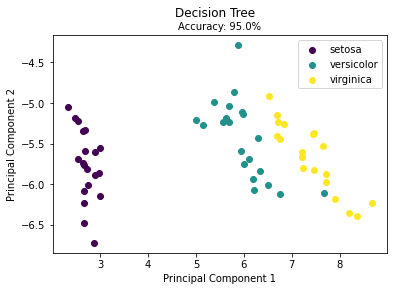

In [45]:
from sklearn.model_selection import train_test_split

def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

print ("-- Classification Tree --")

data = datasets.load_iris()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

clf = ClassificationTree()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print ("Accuracy:", accuracy)

Plot().plot_in_2d(X_test, y_pred, 
    title="Decision Tree", 
    accuracy=accuracy, 
    legend_labels=data.target_names)



## Regression Tree example

-- Regression Tree --


/Users/nesara/Documents/aim/cs/coding/ml-algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()


Mean Squared Error: 124.71231900826447


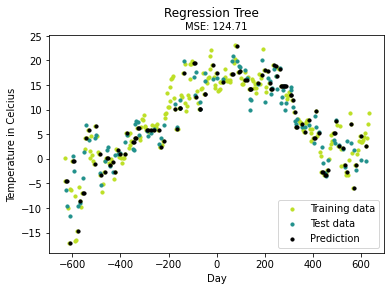

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split

def mean_squared_error(y_true, y_pred):
    """ Returns the mean squared error between y_true and y_pred """
    mse = np.mean(np.power(y_true - y_pred, 2))
    return mse

print ("-- Regression Tree --")

# Load temperature data
data = pd.read_csv('../data/TempLinkoping2016.txt', sep="\t")

time = np.atleast_2d(data["time"].values).T
temp = np.atleast_2d(data["temp"].values).T

X = standardize(time)        # Time. Fraction of the year [0, 1]
y = temp[:, 0]  # Temperature. Reduce to one-dim

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

model = RegressionTree()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

y_pred_line = model.predict(X)

# Color map
cmap = plt.get_cmap('viridis')

mse = mean_squared_error(y_test, y_pred)

print ("Mean Squared Error:", mse)

# Plot the results
# Plot the results
m1 = plt.scatter(366 * X_train, y_train, color=cmap(0.9), s=10)
m2 = plt.scatter(366 * X_test, y_test, color=cmap(0.5), s=10)
m3 = plt.scatter(366 * X_test, y_pred, color='black', s=10)
plt.suptitle("Regression Tree")
plt.title("MSE: %.2f" % mse, fontsize=10)
plt.xlabel('Day')
plt.ylabel('Temperature in Celcius')
plt.legend((m1, m2, m3), ("Training data", "Test data", "Prediction"), loc='lower right')
plt.show()


### Random Forest example

/Users/nesara/Documents/aim/cs/coding/ml-algorithms/env/lib/python3.6/site-packages/ipykernel_launcher.py:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  # This is added back by InteractiveShellApp.init_path()
Training: 100% [------------------------------------------------] Time: 0:01:05


Accuracy: 0.8720445062586927


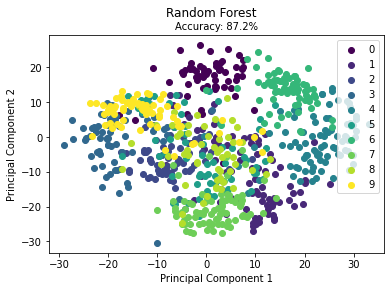

In [33]:
from sklearn.model_selection import train_test_split

def accuracy_score(y_true, y_pred):
    """ Compare y_true to y_pred and return the accuracy """
    accuracy = np.sum(y_true == y_pred, axis=0) / len(y_true)
    return accuracy

data = datasets.load_digits()
X = data.data
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

clf = RandomForest(n_estimators=30)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print ("Accuracy:", accuracy)

Plot().plot_in_2d(X_test, y_pred, title="Random Forest", accuracy=accuracy, legend_labels=data.target_names)

In [10]:
import progressbar
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
import numpy as np

def standardize(X):
    """ Standardize the dataset X """
    X_std = X
    mean = X.mean(axis=0)
    std = X.std(axis=0)
    for col in range(np.shape(X)[1]):
        if std[col]:
            X_std[:, col] = (X_std[:, col] - mean[col]) / std[col]
    # X_std = (X - X.mean(axis=0)) / X.std(axis=0)
    return X_std

def calculate_covariance_matrix(X, Y=None):
    """ Calculate the covariance matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance_matrix = (1 / (n_samples-1)) * (X - X.mean(axis=0)).T.dot(Y - Y.mean(axis=0))

    return np.array(covariance_matrix, dtype=float)
 

def calculate_correlation_matrix(X, Y=None):
    """ Calculate the correlation matrix for the dataset X """
    if Y is None:
        Y = X
    n_samples = np.shape(X)[0]
    covariance = (1 / n_samples) * (X - X.mean(0)).T.dot(Y - Y.mean(0))
    std_dev_X = np.expand_dims(calculate_std_dev(X), 1)
    std_dev_y = np.expand_dims(calculate_std_dev(Y), 1)
    correlation_matrix = np.divide(covariance, std_dev_X.dot(std_dev_y.T))

    return np.array(correlation_matrix, dtype=float)


bar_widgets = [
    'Training: ', progressbar.Percentage(), ' ', progressbar.Bar(marker="-", left="[", right="]"),
    ' ', progressbar.ETA()
]

class Plot():
    def __init__(self): 
        self.cmap = plt.get_cmap('viridis')

    def _transform(self, X, dim):
        covariance = calculate_covariance_matrix(X)
        eigenvalues, eigenvectors = np.linalg.eig(covariance)
        # Sort eigenvalues and eigenvector by largest eigenvalues
        idx = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[idx][:dim]
        eigenvectors = np.atleast_1d(eigenvectors[:, idx])[:, :dim]
        # Project the data onto principal components
        X_transformed = X.dot(eigenvectors)

        return X_transformed


    def plot_regression(self, lines, title, axis_labels=None, mse=None, scatter=None, legend={"type": "lines", "loc": "lower right"}):
        
        if scatter:
            scatter_plots = scatter_labels = []
            for s in scatter:
                scatter_plots += [plt.scatter(s["x"], s["y"], color=s["color"], s=s["size"])]
                scatter_labels += [s["label"]]
            scatter_plots = tuple(scatter_plots)
            scatter_labels = tuple(scatter_labels)

        for l in lines:
            li = plt.plot(l["x"], l["y"], color=s["color"], linewidth=l["width"], label=l["label"])

        if mse:
            plt.suptitle(title)
            plt.title("MSE: %.2f" % mse, fontsize=10)
        else:
            plt.title(title)

        if axis_labels:
            plt.xlabel(axis_labels["x"])
            plt.ylabel(axis_labels["y"])

        if legend["type"] == "lines":
            plt.legend(loc="lower_left")
        elif legend["type"] == "scatter" and scatter:
            plt.legend(scatter_plots, scatter_labels, loc=legend["loc"])

        plt.show()



    # Plot the dataset X and the corresponding labels y in 2D using PCA.
    def plot_in_2d(self, X, y=None, title=None, accuracy=None, legend_labels=None):
        X_transformed = self._transform(X, dim=2)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        class_distr = []

        y = np.array(y).astype(int)

        colors = [self.cmap(i) for i in np.linspace(0, 1, len(np.unique(y)))]

        # Plot the different class distributions
        for i, l in enumerate(np.unique(y)):
            _x1 = x1[y == l]
            _x2 = x2[y == l]
            _y = y[y == l]
            class_distr.append(plt.scatter(_x1, _x2, color=colors[i]))

        # Plot legend
        if not legend_labels is None: 
            plt.legend(class_distr, legend_labels, loc=1)

        # Plot title
        if title:
            if accuracy:
                perc = 100 * accuracy
                plt.suptitle(title)
                plt.title("Accuracy: %.1f%%" % perc, fontsize=10)
            else:
                plt.title(title)

        # Axis labels
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')

        plt.show()

    # Plot the dataset X and the corresponding labels y in 3D using PCA.
    def plot_in_3d(self, X, y=None):
        X_transformed = self._transform(X, dim=3)
        x1 = X_transformed[:, 0]
        x2 = X_transformed[:, 1]
        x3 = X_transformed[:, 2]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x1, x2, x3, c=y)
        plt.show()